In [2]:
import numpy as np
import torch
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import transforms, models, datasets
from tqdm.auto import tqdm
import timm
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image




In [38]:
classes = ['Aortic enlargement', 'Atelectasis','Calcification', 'Cardiomegaly', 'Consolidation','ILD', 'Infiltration','Lung Opacity','Nodule/Mass','Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis', 'No finding']

### Model: Experiment 6

In [40]:
model = timm.models.efficientnet_b0(pretrained=False)
model.load_state_dict(torch.load("/scratch/scratch6/akansh12/DeepEXrays/radiologist_selection/eff_bo.pt"))
from collections import OrderedDict
from torch import nn
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1280,15)),
    ('out', nn.Sigmoid()),
]))
state_dict = torch.load('/scratch/scratch6/akansh12/DeepEXrays/radiologist_selection/final/fnal_eff_b00.191608_8_0.8850654605002062_.pth', map_location = 'cpu')['state_dict']
for keyA, keyB in zip(state_dict, model.state_dict()):
    state_dict = OrderedDict((keyB if k == keyA else k, v) for k, v in state_dict.items())
model.load_state_dict(state_dict)

<All keys matched successfully>

In [41]:
data_transforms = {
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =  [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])        
    ])
}

In [91]:
class fourteen_class(Dataset):
    def __init__(self, label_loc, img_location, transform,  data_type= 'train'):
        label_dataframe = pd.read_csv(label_loc)
        label_dataframe.set_index("image_id", inplace = True)
        filenames = label_dataframe.index.values
        self.full_filename = [os.path.join(img_location,i+'.png') for i in filenames]
        self.labels = label_dataframe.iloc[:].values
        self.transform = transform
    def __len__(self):
        return len(self.full_filename)
    
    def __getitem__(self, idx):
        
        image = Image.open(self.full_filename[idx])
        image = self.transform(image)
        return image, self.labels[idx]

train_data = fourteen_class("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/14_class/labels/exp_6.csv",
                                       img_location = "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/train/", transform =data_transforms['test'])
test_data = fourteen_class("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/14_class/labels/test.csv",
                                       img_location = "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/test/", transform =data_transforms['test'])

trainloader = DataLoader(train_data,batch_size = 1,shuffle = False)
testloader = DataLoader(test_data,batch_size = 1,shuffle = False)

 
train_label = pd.read_csv("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/14_class/labels/exp_6.csv")
test_label =  pd.read_csv("/storage/home/akansh12/Vin-ChestXR-Abnormality-detection/Notebooks/14_class/labels/test.csv")

annotation = {'train': train_label, 'test': test_label}

In [43]:
def img2tensor(image_name, data_type = 'train'):
    img_1 = Image.open(f"/scratch/scratch6/akansh12/DeepEXrays/data/data_256/{data_type}/{image_name}.png")
    return torch.unsqueeze(data_transforms['test'](img_1), dim = 0), annotation[f'{data_type}'].set_index('image_id').loc[image_name].values

In [65]:
def read_img(image_name, data_type = 'train'):
    img_1 = plt.imread(f"/scratch/scratch6/akansh12/DeepEXrays/data/data_256/{data_type}/{image_name}.png")
    return img_1

### GradCam

In [87]:
model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
   

In [88]:
target_layers = [model.blocks[6]]  ## for Efficientnet B0

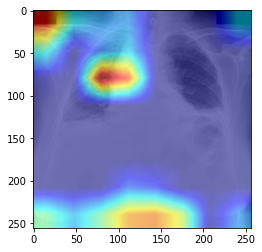

In [103]:
input_tensor, ann = img2tensor('00150343289f317a0ad5629d5b7d9ef9')
rgb_img = read_img('00150343289f317a0ad5629d5b7d9ef9')

cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=False)

### select category
category = 0

''' ['Aortic enlargement', 
'Atelectasis','Calcification', 'Cardiomegaly',
'Consolidation','ILD', 'Infiltration','Lung Opacity',
'Nodule/Mass','Other lesion', 'Pleural effusion', 
'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis', 'No finding'] '''

grayscale_cam = cam(input_tensor=input_tensor, target_category=category)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
plt.imshow(visualization)